In [1]:
import os.path
import json
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
figdir = 'figures/disk_key_value_readonly'
!mkdir -p $figdir

In [3]:
duration_seconds = 10

results = []
with open('../benchmarks/disk_key_value/readonly/local_2020_04_15.jsonl', 'rt') as fp:
    for line in fp:
        spec, counts = json.loads(line)
        spec.update(counts)
        results.append(spec)
results = pd.DataFrame(results)

results['index'] = results['index_path'].map(os.path.basename)
results = results.drop(['data_path', 'known_keys_data_path', 'key_set_size', 'index_path'], axis=1)


results.sample(5)

,known_key_get_frac,read_threads,seconds,trial_index,get,found,index
12,0.9,64,10,1,52962,47799,index
77,0.1,16,10,8,486061,48688,index2
20,0.1,64,10,5,55419,5434,index
83,0.1,64,10,6,528298,53245,index2
8,0.1,16,10,2,51869,5214,index


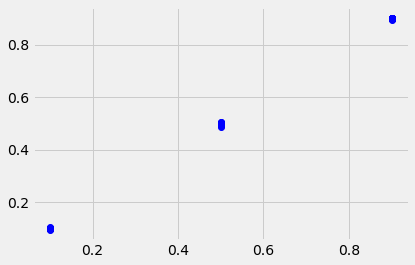

In [4]:
plt.plot(results['known_key_get_frac'], results['found'] / results['get'], 'bo')

In [5]:
agg = results.groupby(['index', 'known_key_get_frac', 'read_threads'])['get'].describe()
agg

count           mean           std  \
index  known_key_get_frac read_threads                                       
index  0.1                1               5.0    6551.400000    422.187518   
                          4               5.0   28203.400000   1042.622799   
                          16              2.0   52234.500000    516.895057   
                          64              9.0   55482.333333   2084.040907   
       0.5                1               6.0    7146.500000    194.671775   
                          4               6.0   29469.833333    363.307813   
                          16              4.0   51874.250000   3990.481957   
                          64              6.0   55463.500000   2828.325211   
       0.9                1               6.0    7752.166667     84.117576   
                          4               3.0   31245.666667    231.884310   
                          16              4.0   55964.500000    428.692197   
                          64              7.0   56784.142857   4156.850427   
index2 0.1                1               6.0   64279.166667   1752.862849   
                          4               5.0  284408.200000   3153.417939   
                          16              7.0  515943.142857  19006.353740   
                          64              8.0  522311.250000  25437.600677   
       0.5                1               4.0   64756.000000   1016.961160   
                          4               8.0  284712.500000   5179.231576   
                          16              6.0  521119.166667  18831.731258   
                          64              6.0  534701.833333  33963.749460   
       0.9                1               8.0   70062.250000    293.024499   
                          4               3.0  292283.333333   1687.404615   
                          16              7.0  537993.142857  16132.277163   
                          64              4.0  553712.000000  18710.281273   

                                             min        25%       50%  \
index  known_key_get_frac read_threads                                  
index  0.1                1               5868.0    6497.00    6599.0   
                          4              26874.0   27325.00   28681.0   
                          16             51869.0   52051.75   52234.5   
                          64             50390.0   55419.00   55995.0   
       0.5                1               6875.0    7023.25    7185.5   
                          4              29042.0   29284.00   29338.5   
                          16             45944.0   51442.25   53488.0   
                          64             50527.0   54873.00   56082.0   
       0.9                1               7667.0    7690.25    7736.0   
                          4              31046.0   31118.50   31191.0   
                          16             55652.0   55701.50   55809.0   
                          64             51855.0   53611.50   56095.0   
index2 0.1                1              60834.0   64498.25   64666.5   
                          4             280716.0  281937.00  285107.0   
                          16            486061.0  507128.50  514562.0   
                          64            477777.0  513759.25  527625.0   
       0.5                1              63793.0   63925.00   64744.5   
                          4             273694.0  283598.75  285301.0   
                          16            502085.0  505493.00  517432.5   
                          64            496434.0  515959.25  521466.0   
       0.9                1              69715.0   69867.25   70003.0   
                          4             290575.0  291450.50  292326.0   
                          16            511333.0  529105.50  538418.0   
                          64            533697.0  540159.00  554054.0   

                                              75%       max  
index  known_key_get_frac read_threads            

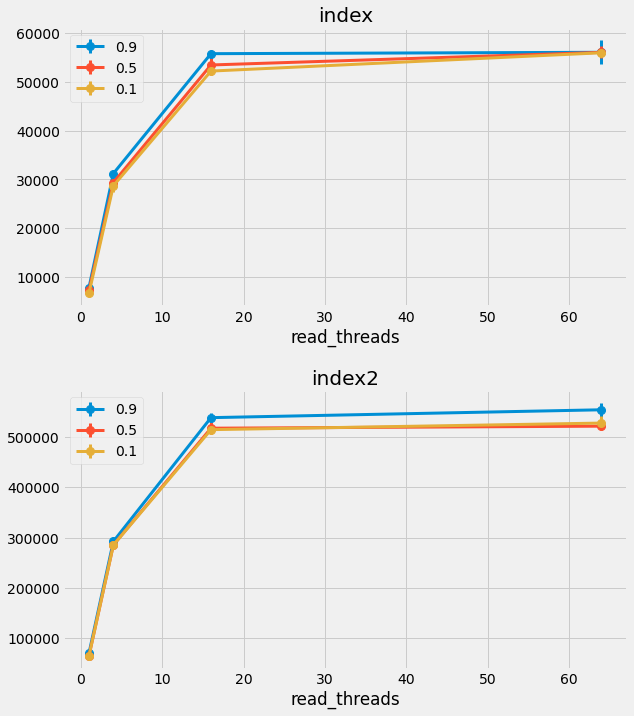

In [6]:
fig = plt.figure(figsize=(9, 11))
fig.subplots_adjust(hspace=0.3)
for i,(index, x) in enumerate(agg.reset_index().groupby('index')):
    ax = fig.add_subplot(2, 1, i+1)
    ax.set_title(index)
    for kkgf, x in list(x.groupby('known_key_get_frac'))[::-1]:
        x = x.set_index('read_threads')
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']
        x.plot(ax=ax, y='50%', yerr=iq.values.T, label=kkgf, marker='o', ms=8, lw=3)

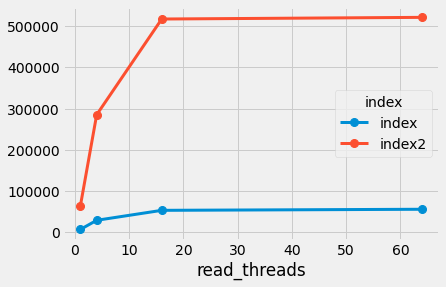

In [7]:
x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x.groupby(['index', 'read_threads'])['50%'].apply(lambda x: x.iloc[0]).unstack().T
x
x.plot(lw=3, ms=8, marker='o')